In [5]:
#필요한 패키지 import
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
import csv
import sys
import random
import pickle

csv.field_size_limit(sys.maxsize)
%matplotlib inline

In [4]:
# 정제한 data load
raw_list = []
with open("full_sentences.tsv", "r") as infile:
    tsvin = csv.reader(infile, delimiter='\t')

    for item in list(tsvin):
        if len(item) >= 3:
            raw_list.append({'uid': item[0], 'tags': item[1], 'words': item[2]})
            
print('총 %d건' % len(raw_list))
raw_list[:5]

FileNotFoundError: [Errno 2] No such file or directory: 'full_sentences.tsv'

In [365]:
# data 임의 추출
random.shuffle(raw_list)
raw_list = raw_list[:5000]
random.shuffle(raw_list)
uid_list = [i['uid'] for i in raw_list]
words_list = [i['words'] for i in raw_list]
tags_list = [i['tags'] for i in raw_list]

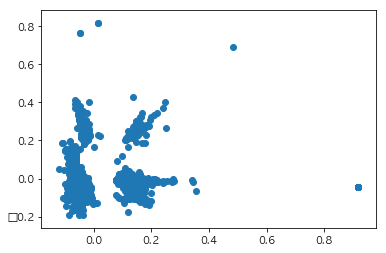

In [366]:
#CountVectorizer -> TfidfTransformer -> PCA형태로 document가공 후 그래프로 표현
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

X = pipeline.fit_transform(tags_list).todense()

#Save vectorizer.vocabulary_
pickle.dump(pipeline.steps[0][1].vocabulary_,open("feature.pkl","wb"))

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

In [367]:
# 정제된 pca 좌표를 kmeans 알고리즘으로 클러스터링
num_clusters = 5
km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
%time km.fit(data2D)
clusters = km.labels_.tolist()

CPU times: user 4.86 ms, sys: 1.32 ms, total: 6.18 ms
Wall time: 4.87 ms


[-0.21974645 -0.19974645 -0.17974645 ...,  0.96025355  0.98025355
  1.00025355] (5000, 6846) (3782, 2)


([], <a list of 0 Text yticklabel objects>)

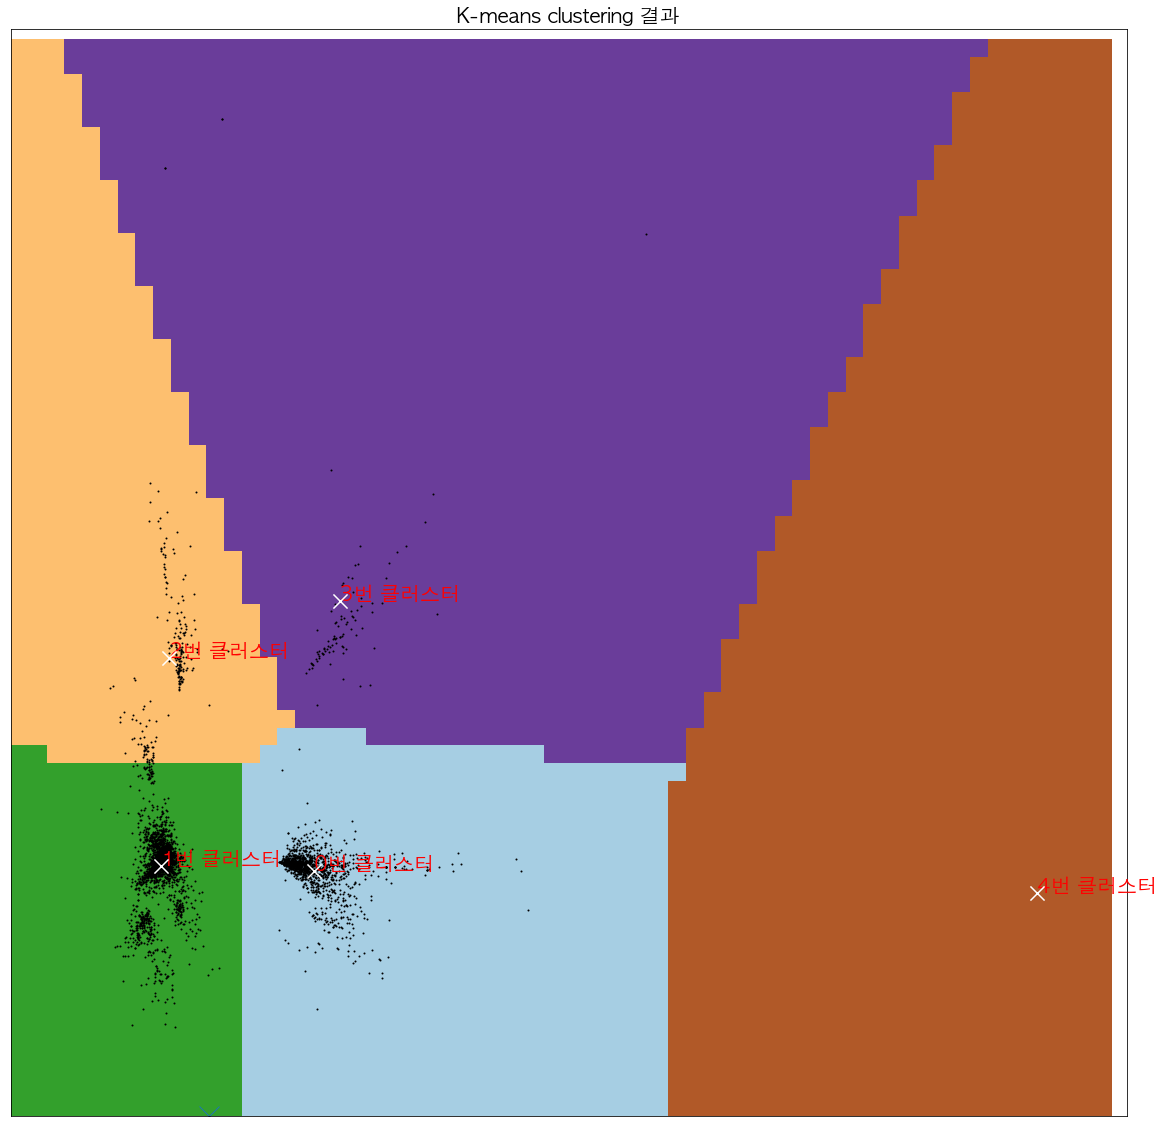

In [368]:
# kmeans로 클러스터링 결과를 그래프로 보여줌
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data2D[:, 0].min() - 0.1, data2D[:, 0].max() + 0.1
y_min, y_max = data2D[:, 1].min() - 0.1, data2D[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

print(xx.ravel(), X.shape, np.c_[xx.ravel(), yy.ravel()].shape)
# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


font_name = font_manager.FontProperties(fname="/Library/Fonts/AppleGothic.ttf").get_name()
plt.rc('font', family=font_name)  
plt.figure(figsize=(20, 20))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(data2D[:, 0], data2D[:, 1], 'k.', markersize=2)
plt.plot(0, y_min, marker='x', markersize=20)
# Plot the centroids as a white X
centroids = km.cluster_centers_

for i in range(len(centroids)):
    plt.scatter(centroids[i][0], centroids[i][1],
                marker='x', label=str(i), s=200, linewidths=3,
                color='w', zorder=10)
    plt.annotate(str(i)+'번 클러스터', xy=(centroids[i][0], centroids[i][1]), color='red', size=20)
plt.title('K-means clustering 결과', size=20)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [309]:
#클러스터링 결과값을 index로 하여 uid, tags, words구조로 만들어줌
sents = {'uid': uid_list, 'tags': tags_list, 'words': words_list, 'cluster': clusters}
frame = pd.DataFrame(sents, index = [clusters] , columns = ['uid', 'tags', 'words', 'cluster'])

In [274]:
%time km.fit(X)
clusters = km.labels_.tolist()

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms = pipeline.steps[0][1].get_feature_names()

for i in range(num_clusters):
    print("%d:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind], end=',')
    print()

CPU times: user 16.5 s, sys: 1.93 s, total: 18.4 s
Wall time: 17.4 s
0: 사람, 생각, 연애, 친구, 결혼, 사랑,
1: 질문, 사용, 정도, 추천, 혹시, 만원,
2: 게임, 플스, 위닝, 질문, 가격, 중고,
3: 오늘, 운동, 아침, 하루, 시작, 세트,
4: 내용, 삭제, 노출, 장기, 달리, 수정,


In [351]:
frame.loc[frame['cluster'] == 3]

,uid,tags,words,cluster
3,d12c5d21357a955cf51321077105946e,오늘 그냥 수영 일차 날씨,수영 일차 오늘 날씨 기분 우울 몸무게 계속 고요 오늘 그냥 시간 걷기 킥판 자유형...,3
3,b37e30aaeba716f9da0bba8897b646a8,펩시 오늘 편의점 마치 담배,펩시 오늘 마치 편의점 담배 잠깐 오늘 커피 음료수 코너 발매 펩시 콜라 체리 그냥...,3
3,4dc2ecd9d76257ec658c303935ef0c80,내비 현대차 오늘 망조 안내,현대차 느낌 동안 이익 계속 신문 기사 이전 오늘 망조 내비 월매 린지 빙빙 안내 ...,3
3,9de693972ee166a29c9039f8f4c7e2ea,오늘 게임 사람 로망 아직,게임 사람 로망 직전 아직 가슴 새근반 오늘 드디어 남자 로망 게임 사람 망인 대화...,3
3,1a828e24970fa353aeb132457e132d06,번개 교보 로비 정보 오늘,정보 오늘 번개 모임 오후 교보 로비 친목 도모 번개 상관 신규 여성 유저 밥값 무...,3
3,610ad80a62ad20ef4395add137bde115,오늘 서울 부산 방면 고속도로,오늘 서울 부산 방면 고속도로 은색 포르쉐 보배 흰색 포엿습니,3
3,046d66e75ac1ce76a8f5e160e1fd5197,오늘 달리기 자전거 페이스 어제,오늘 달리기 어제 자전거 생각 대신 느낌 남아 자전거 오늘 달리기 마라톤 대회 대비...,3
3,7e58756797b1c107036dd2f9c9f382af,오늘 운동 쭉쭉때 유산 소조,오늘 운동 쭉쭉때 오늘 유산 소조 내일 러닝 연습,3
3,4458c86d21d0b2502b0abcfa77afff5b,이론 게시판 오늘 연애 사람,이론 게시판 오늘 연애 이론 사람,3
3,578b9877175c1d5d7fa3c5e889fa8c0e,불금 퐈이 오늘 선물 세팅,불금 퐈이 오늘 선물 세팅 흐흐 불금,3


In [279]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(data2D)

dist.shape

(5000, 5000)

In [284]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

ValueError: array must be 2-dimensional and square. shape = (5000, 19527)

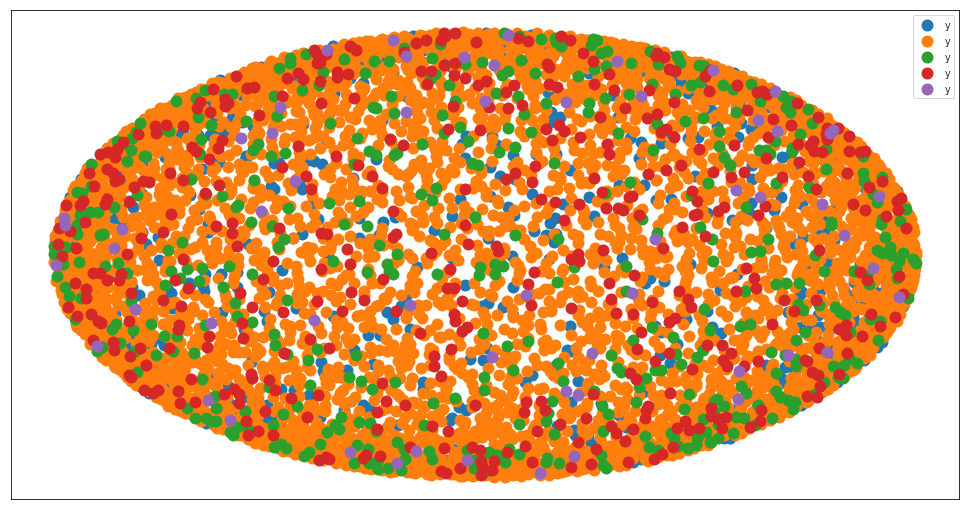

In [280]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tags_list)) 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], '', size=8)

In [321]:
lda = LatentDirichletAllocation(n_topics=5, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X)

/Users/yunsungkim/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


TypeError: '<' not supported between instances of 'numpy.ndarray' and 'int'

In [294]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [324]:
print_top_words(lda, terms, 10)
terms

AttributeError: 'LatentDirichletAllocation' object has no attribute 'components_'